In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots, add_identity
from collections import Counter
from matplotlib.lines import Line2D
from tqdm import tqdm
from sklearn.model_selection import GroupKFold, cross_val_predict
from sklearn.ensemble import RandomForestRegressor  # or any regressor you use
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_error, median_absolute_error

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

image_ctx = {'image.cmap': 'cubehelix', 'image.interpolation': 'none'}

In [5]:
## arrange data
## arrange data for females
keep_syllables = np.loadtxt('to_keep_syllables_raw.txt', dtype=int)

female_df = pd.read_parquet('ontogeny_females_raw_usage_matrix_v00.parquet').astype(float)
female_df = female_df[keep_syllables]

# for female:
f_df= female_df.groupby(['age','uuid']).mean()
# Update age value to 52 for rows with uuid in the list
uuids = ['f1d5dce5-f5cf-4b03-b07d-d9b8c1f034b0','6fa50ac7-6d49-4ef9-9059-3d90bdd8c5d4',
         'e9e05da8-fc59-40f3-a9c8-f57c492c6141','327e7fa1-2237-43d2-b25f-c1801912df33',
        '242bee8e-0ee7-45e7-8a13-678836a4cddb','552ec70f-0676-4471-8ab0-403e1fcf43e3','d6f254af-d55a-427a-96e0-c452a233cbe2']
f_df.reset_index(inplace=True)

age_mapping = {
    93: 94,
    95: 94,
    97: 98,
    98: 98,
    102: 98,
    103: 105,
    105: 105,
    107: 105
}

f_df['age'] = f_df['age'].map(age_mapping).fillna(f_df['age'])
f_df.loc[f_df['uuid'].isin(uuids), 'age'] = 52
# Set the index back
f_df.set_index(['age', 'uuid'], inplace=True)
f_df=f_df.query('age<127')

In [6]:
# choose a model for decoder
clf = PLSRegression(n_components=5)
cv = LeaveOneOut()
#number of iterations for shuffle
it=100

In [7]:
format_plots()

In [8]:
#prepare data
#data=f_norm.copy()
data=f_df.copy()
y_age =data.index.get_level_values('age').to_numpy()
X=data.to_numpy()

In [9]:
#decoder
y_pred = cross_val_predict(clf, X, y_age, cv=cv)
r2_age = r2_score(y_age, y_pred)
print(r2_age)

0.719102558701217


In [10]:
res_age = y_age.flatten()-y_pred.flatten()
res_less = res_age[res_age<0]
res_more = res_age[res_age>0]
print(np.mean(abs(res_less)))
print(np.mean(abs(res_more)))

12.027676438664386
12.016001375387356


In [11]:
df_res = pd.DataFrame(res_age)
df_res['age'] = y_age.flatten()

In [11]:
from scipy.stats import pearsonr
print(pearsonr(y_age, y_pred.flatten()))

PearsonRResult(statistic=0.8486856588353167, pvalue=2.428149333144917e-101)


In [12]:
# Calculating Mean Absolute Error (MAE)
mae_age = median_absolute_error(y_age, y_pred)
print("Median Absolute Error (MAE):", mae_age)

Median Absolute Error (MAE): 9.401149033061955


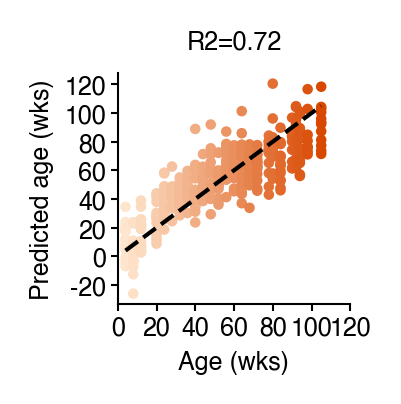

In [12]:
fig = figure(1, 1)
ax = fig.gca()
plt.scatter(y_age, y_pred, c=y_age, cmap=cmf, s=3)
#add_identity(ax, ls='--', color='k', zorder=-1)
ax.set(xlim=(0, None),yticks=[-20,0, 20, 40, 60,80,100, 120], xticks=[0, 20, 40, 60,80,100,120], xlabel="Age (wks)", ylabel="Predicted age (wks)", 
       title=f"R2={r2_age:0.2f}",
      )
plt.plot(y_age, y_age, linestyle='--', color='black')
sns.despine()

In [13]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig1"/ 'Age_regression_female.pdf', bbox_inches='tight')

In [14]:
#shuffle
ysh_score_age=[]
ysh_age=[]
ysh_predict_age=[]
ysh_mse_age=[]
for i in tqdm(range(it)):
    ysh_temp=np.random.permutation(y_age)
    y_pred_temp = cross_val_predict(clf, X, ysh_temp, cv=cv, n_jobs=-1)
    ysh_score_age.append(r2_score(y_age, y_pred_temp))
    ysh_age.extend(ysh_temp)
    ysh_predict_age.extend(y_pred_temp)
    ysh_mse_age.append(mean_squared_error(y_age, y_pred_temp))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [13:37<00:00,  8.18s/it]


/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


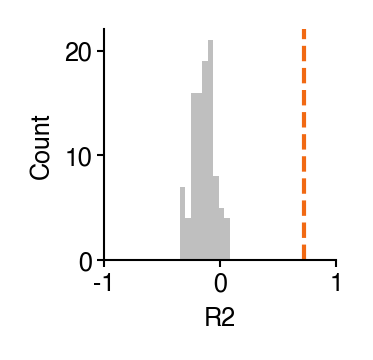

In [15]:
fig = plt.figure(figsize=(1, 1))
fig.dpi = 300
ax = sns.histplot(data=ysh_score_age, fill=True, element='step', lw=0, color='black', alpha=0.25)
ax.axvline(r2_age, color='#f16913', lw=1, linestyle='--')

ax.set(ylabel='Count')
ax.set(xlabel='R2')
plt.xlim([-1,1])
sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig1"/ 'Age_regression_female_shuf.pdf', bbox_inches='tight')

In [13]:
## leave one age out

In [14]:
# Prepare data
data = f_df.copy()

# Extract features and target
X = data.to_numpy()
y = data.index.get_level_values('age').to_numpy()
groups = data.index.get_level_values('age').to_numpy()

cv = LeaveOneGroupOut()
cv.get_n_splits(X, y, groups)

# decoder
y_age=y
y_pred = cross_val_predict(clf, X, y_age, groups=groups, cv=cv, n_jobs=-1)
r2_age = r2_score(y_age, y_pred)

In [15]:
from scipy.stats import pearsonr
print(pearsonr(y_age, np.array(y_pred).flatten()))

PearsonRResult(statistic=0.8154779610012715, pvalue=2.86164218162178e-87)


In [16]:
# Calculating Mean Absolute Error (MAE)
mae_age = median_absolute_error(y_age, y_pred)
print("Median Absolute Error (MAE):", mae_age)

Median Absolute Error (MAE): 10.953567834622717


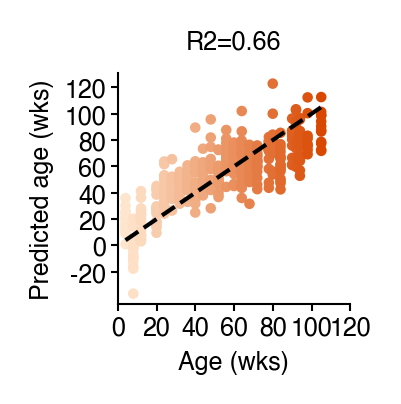

In [20]:
fig = figure(1, 1)
ax = fig.gca()
plt.scatter(y_age, y_pred, c=y_age, cmap=cmf, s=3)
#add_identity(ax, ls='--', color='k', zorder=-1)
ax.set(xlim=(0, None),yticks=[-20,0, 20, 40, 60,80,100,120], xticks=[0, 20, 40, 60,80,100,120], xlabel="Age (wks)", ylabel="Predicted age (wks)", 
       title=f"R2={r2_age:0.2f}",
      )
plt.plot(y_age, y_age, linestyle='--', color='black')
sns.despine()

In [21]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig1"/ 'Age_regression_female_age_out.pdf', bbox_inches='tight')

In [22]:
## shuffle
#shuffle
ysh_score_age=[]
ysh_age=[]
ysh_predict_age=[]
ysh_mse_age=[]
for i in tqdm(range(it)):
    ysh_temp=np.random.permutation(y_age)
    y_pred_temp = cross_val_predict(clf, X, ysh_temp, groups=groups, cv=cv, n_jobs=-1)
    ysh_score_age.append(r2_score(y_age, y_pred_temp))
    ysh_age.extend(ysh_temp)
    ysh_predict_age.extend(y_pred_temp)
    ysh_mse_age.append(mean_squared_error(y_age, y_pred_temp))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


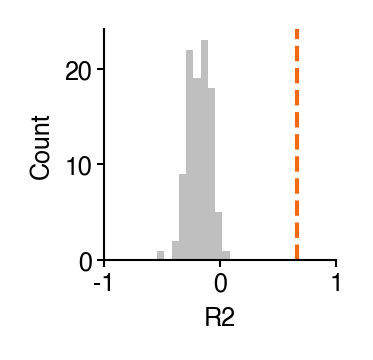

In [23]:
fig = plt.figure(figsize=(1, 1))
fig.dpi = 300
ax = sns.histplot(data=ysh_score_age, fill=True, element='step', lw=0, color='black', alpha=0.25)
ax.axvline(r2_age, color='#f16913', lw=1, linestyle='--')

ax.set(ylabel='Count')
ax.set(xlabel='R2')
plt.xlim([-1,1])
sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig1"/ 'Age_regression_age_out_female_shuf.pdf', bbox_inches='tight')